# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter-yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

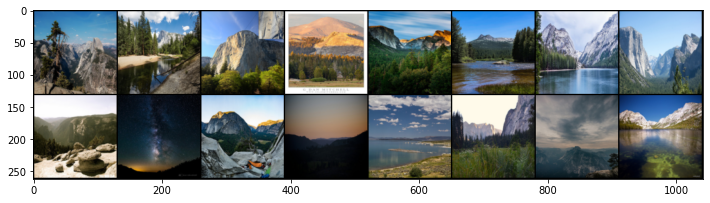

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

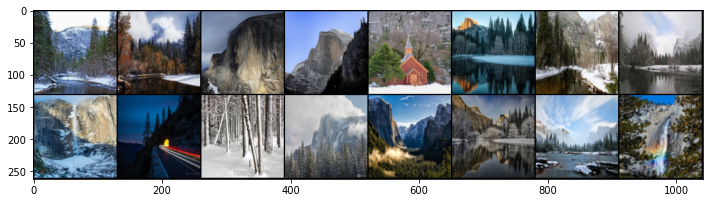

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0392)
Max:  tensor(0.9843)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9216)
Scaled max:  tensor(0.9686)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)
        self.conv5 = conv(conv_dim * 8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        out = self.conv5(x)
        
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, kernel_size = 3, stride = 1)
        self.conv2 = conv(conv_dim, conv_dim, kernel_size = 3, stride = 1)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        resnet_out = self.conv2(F.relu(self.conv1(x)))
        
        return x + resnet_out
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.encoder = nn.Sequential(
            conv(3, conv_dim, 4),
            nn.ReLU(),
            conv(conv_dim, conv_dim * 2, 4),
            nn.ReLU(),
            conv(conv_dim * 2, conv_dim * 4, 4),
            nn.ReLU()
        )
        # 2. Define the resnet part of the generator
        resnet_blocks = [ResidualBlock(conv_dim * 4) for i in range(n_res_blocks)]
        self.resnet = nn.Sequential(*resnet_blocks)
        
        # 3. Define the decoder part of the generator
        self.decoder = nn.Sequential(
            deconv(conv_dim * 4, conv_dim * 2, 4),
            nn.ReLU(),
            deconv(conv_dim * 2, conv_dim, 4),
            nn.ReLU(),
            deconv(conv_dim, 3, 4, batch_norm=False),
            nn.Tanh()
        )

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        encoded_input = self.encoder(x)
        encoded_processed = self.resnet(encoded_input)
        out = self.decoder(encoded_processed)
        
        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU()
  )
  (resnet): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Batch

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    loss = torch.mean((D_out - 1)**2)
    return loss
    

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    loss = torch.mean((D_out)**2)
    return loss

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im)) * lambda_weight
    return loss
    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
         # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_Y = G_XtoY(images_X)
        
        # 3. Compute the fake loss for D_X
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)
        
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)
        
        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)
                
        
        ##    Second: generate fake Y images and reconstructed X images    ##
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_Y = G_XtoY(images_X)
        
        # 2. Compute the generator loss based on domain X
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)
        
        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)
        
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [27]:
n_epochs = 4000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.0507 | d_Y_loss: 0.0474 | g_total_loss: 1.6794
Epoch [   20/ 4000] | d_X_loss: 0.0824 | d_Y_loss: 0.1103 | g_total_loss: 1.5583
Epoch [   30/ 4000] | d_X_loss: 0.0171 | d_Y_loss: 0.0207 | g_total_loss: 1.8872
Epoch [   40/ 4000] | d_X_loss: 0.0698 | d_Y_loss: 0.1205 | g_total_loss: 2.0419
Epoch [   50/ 4000] | d_X_loss: 0.0490 | d_Y_loss: 0.0505 | g_total_loss: 1.6215
Epoch [   60/ 4000] | d_X_loss: 0.0248 | d_Y_loss: 0.0219 | g_total_loss: 2.2371
Epoch [   70/ 4000] | d_X_loss: 0.0095 | d_Y_loss: 0.0099 | g_total_loss: 2.1349
Epoch [   80/ 4000] | d_X_loss: 0.0843 | d_Y_loss: 0.2060 | g_total_loss: 1.4907
Epoch [   90/ 4000] | d_X_loss: 0.0382 | d_Y_loss: 0.0281 | g_total_loss: 2.2970


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.2330 | d_Y_loss: 0.1784 | g_total_loss: 1.7490
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.1383 | d_Y_loss: 0.1393 | g_total_loss: 1.1812
Epoch [  120/ 4000] | d_X_loss: 0.0116 | d_Y_loss: 0.0182 | g_total_loss: 2.0768
Epoch [  130/ 4000] | d_X_loss: 0.0131 | d_Y_loss: 0.0173 | g_total_loss: 2.0186
Epoch [  140/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.0373 | g_total_loss: 2.0490
Epoch [  150/ 4000] | d_X_loss: 0.0205 | d_Y_loss: 0.0218 | g_total_loss: 1.9325
Epoch [  160/ 4000] | d_X_loss: 0.0341 | d_Y_loss: 0.0833 | g_total_loss: 1.9623
Epoch [  170/ 4000] | d_X_loss: 0.0284 | d_Y_loss: 0.0511 | g_total_loss: 1.5996
Epoch [  180/ 4000] | d_X_loss: 0.0242 | d_Y_loss: 0.0207 | g_total_loss: 1.9603
Epoch [  190/ 4000] | d_X_loss: 0.0424 | d_Y_loss: 0.1048 | g_total_loss: 1.9303


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.0793 | d_Y_loss: 0.0456 | g_total_loss: 1.5500
Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.0165 | d_Y_loss: 0.0172 | g_total_loss: 2.0203
Epoch [  220/ 4000] | d_X_loss: 0.0270 | d_Y_loss: 0.0266 | g_total_loss: 2.2597
Epoch [  230/ 4000] | d_X_loss: 0.0331 | d_Y_loss: 0.0281 | g_total_loss: 2.1055
Epoch [  240/ 4000] | d_X_loss: 0.0535 | d_Y_loss: 0.0424 | g_total_loss: 1.9731
Epoch [  250/ 4000] | d_X_loss: 0.0373 | d_Y_loss: 0.1432 | g_total_loss: 1.9720
Epoch [  260/ 4000] | d_X_loss: 0.0184 | d_Y_loss: 0.0241 | g_total_loss: 1.8008
Epoch [  270/ 4000] | d_X_loss: 0.0119 | d_Y_loss: 0.0161 | g_total_loss: 2.2420
Epoch [  280/ 4000] | d_X_loss: 0.0687 | d_Y_loss: 0.0521 | g_total_loss: 1.8319
Epoch [  290/ 4000] | d_X_loss: 0.2096 | d_Y_loss: 0.1546 | g_total_loss: 1.2242


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.0172 | d_Y_loss: 0.0096 | g_total_loss: 2.0555
Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.9009 | d_Y_loss: 0.2178 | g_total_loss: 0.9829
Epoch [  320/ 4000] | d_X_loss: 0.0702 | d_Y_loss: 0.0747 | g_total_loss: 1.8679
Epoch [  330/ 4000] | d_X_loss: 0.1192 | d_Y_loss: 0.0371 | g_total_loss: 2.3243
Epoch [  340/ 4000] | d_X_loss: 0.0428 | d_Y_loss: 0.0137 | g_total_loss: 2.1586
Epoch [  350/ 4000] | d_X_loss: 0.1960 | d_Y_loss: 0.0123 | g_total_loss: 2.1046
Epoch [  360/ 4000] | d_X_loss: 0.0601 | d_Y_loss: 0.0430 | g_total_loss: 1.5763
Epoch [  370/ 4000] | d_X_loss: 0.0383 | d_Y_loss: 0.0131 | g_total_loss: 1.8913
Epoch [  380/ 4000] | d_X_loss: 0.1315 | d_Y_loss: 0.0975 | g_total_loss: 2.2859
Epoch [  390/ 4000] | d_X_loss: 0.3755 | d_Y_loss: 0.1138 | g_total_loss: 1.6250


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.0363 | d_Y_loss: 0.0351 | g_total_loss: 2.1553
Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.0299 | d_Y_loss: 0.0164 | g_total_loss: 1.8594
Epoch [  420/ 4000] | d_X_loss: 0.0076 | d_Y_loss: 0.0082 | g_total_loss: 1.9578
Epoch [  430/ 4000] | d_X_loss: 0.3488 | d_Y_loss: 0.2000 | g_total_loss: 1.8558
Epoch [  440/ 4000] | d_X_loss: 0.0291 | d_Y_loss: 0.0293 | g_total_loss: 1.9633
Epoch [  450/ 4000] | d_X_loss: 0.0218 | d_Y_loss: 0.0380 | g_total_loss: 2.1180
Epoch [  460/ 4000] | d_X_loss: 0.0533 | d_Y_loss: 0.0256 | g_total_loss: 1.8980
Epoch [  470/ 4000] | d_X_loss: 0.1746 | d_Y_loss: 0.1677 | g_total_loss: 2.0025
Epoch [  480/ 4000] | d_X_loss: 0.0414 | d_Y_loss: 0.0444 | g_total_loss: 1.7518
Epoch [  490/ 4000] | d_X_loss: 0.6505 | d_Y_loss: 0.3959 | g_total_loss: 1.6902


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.0416 | d_Y_loss: 0.0588 | g_total_loss: 2.3149
Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.1119 | d_Y_loss: 0.0477 | g_total_loss: 1.9397
Epoch [  520/ 4000] | d_X_loss: 0.0234 | d_Y_loss: 0.0101 | g_total_loss: 1.9112
Epoch [  530/ 4000] | d_X_loss: 0.0172 | d_Y_loss: 0.0221 | g_total_loss: 2.1456
Epoch [  540/ 4000] | d_X_loss: 0.0715 | d_Y_loss: 0.0419 | g_total_loss: 2.0239
Epoch [  550/ 4000] | d_X_loss: 0.6779 | d_Y_loss: 0.3487 | g_total_loss: 1.2073
Epoch [  560/ 4000] | d_X_loss: 0.0251 | d_Y_loss: 0.0172 | g_total_loss: 1.9343
Epoch [  570/ 4000] | d_X_loss: 0.2665 | d_Y_loss: 0.2319 | g_total_loss: 1.8349
Epoch [  580/ 4000] | d_X_loss: 0.0307 | d_Y_loss: 0.0474 | g_total_loss: 1.6873
Epoch [  590/ 4000] | d_X_loss: 0.0354 | d_Y_loss: 0.0400 | g_total_loss: 1.9955


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.1321 | d_Y_loss: 0.1666 | g_total_loss: 2.0615
Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.1416 | d_Y_loss: 0.0496 | g_total_loss: 1.6983
Epoch [  620/ 4000] | d_X_loss: 0.0421 | d_Y_loss: 0.0238 | g_total_loss: 1.8835
Epoch [  630/ 4000] | d_X_loss: 0.0252 | d_Y_loss: 0.0129 | g_total_loss: 1.9052
Epoch [  640/ 4000] | d_X_loss: 0.2012 | d_Y_loss: 0.3016 | g_total_loss: 1.5717
Epoch [  650/ 4000] | d_X_loss: 0.3015 | d_Y_loss: 0.1583 | g_total_loss: 1.6445
Epoch [  660/ 4000] | d_X_loss: 0.0301 | d_Y_loss: 0.0237 | g_total_loss: 2.3106
Epoch [  670/ 4000] | d_X_loss: 0.0311 | d_Y_loss: 0.0247 | g_total_loss: 1.9364
Epoch [  680/ 4000] | d_X_loss: 0.0726 | d_Y_loss: 0.0620 | g_total_loss: 1.9499
Epoch [  690/ 4000] | d_X_loss: 0.0195 | d_Y_loss: 0.0226 | g_total_loss: 1.8315


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.0846 | d_Y_loss: 0.0651 | g_total_loss: 2.1787
Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.1102 | d_Y_loss: 0.1012 | g_total_loss: 1.4697
Epoch [  720/ 4000] | d_X_loss: 0.2195 | d_Y_loss: 0.2678 | g_total_loss: 1.5411
Epoch [  730/ 4000] | d_X_loss: 0.0250 | d_Y_loss: 0.0184 | g_total_loss: 1.8847
Epoch [  740/ 4000] | d_X_loss: 0.0579 | d_Y_loss: 0.1005 | g_total_loss: 1.8638
Epoch [  750/ 4000] | d_X_loss: 0.0442 | d_Y_loss: 0.0182 | g_total_loss: 2.0101
Epoch [  760/ 4000] | d_X_loss: 0.0355 | d_Y_loss: 0.0641 | g_total_loss: 1.7869
Epoch [  770/ 4000] | d_X_loss: 0.1174 | d_Y_loss: 0.1222 | g_total_loss: 2.0341
Epoch [  780/ 4000] | d_X_loss: 0.0147 | d_Y_loss: 0.0287 | g_total_loss: 1.9137
Epoch [  790/ 4000] | d_X_loss: 0.0395 | d_Y_loss: 0.0942 | g_total_loss: 1.7200


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.0120 | d_Y_loss: 0.0125 | g_total_loss: 2.0876
Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.0101 | d_Y_loss: 0.0179 | g_total_loss: 1.8537
Epoch [  820/ 4000] | d_X_loss: 0.0197 | d_Y_loss: 0.0397 | g_total_loss: 1.8464
Epoch [  830/ 4000] | d_X_loss: 0.0391 | d_Y_loss: 0.0315 | g_total_loss: 2.1147
Epoch [  840/ 4000] | d_X_loss: 0.0310 | d_Y_loss: 0.0162 | g_total_loss: 1.8685
Epoch [  850/ 4000] | d_X_loss: 0.0286 | d_Y_loss: 0.0375 | g_total_loss: 2.2884
Epoch [  860/ 4000] | d_X_loss: 0.0213 | d_Y_loss: 0.0452 | g_total_loss: 1.6949
Epoch [  870/ 4000] | d_X_loss: 0.0389 | d_Y_loss: 0.0486 | g_total_loss: 2.0192
Epoch [  880/ 4000] | d_X_loss: 0.0782 | d_Y_loss: 0.1892 | g_total_loss: 1.7942
Epoch [  890/ 4000] | d_X_loss: 0.0195 | d_Y_loss: 0.0162 | g_total_loss: 1.9051


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.0308 | d_Y_loss: 0.0265 | g_total_loss: 2.1076
Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.0863 | d_Y_loss: 0.0866 | g_total_loss: 2.0799
Epoch [  920/ 4000] | d_X_loss: 0.1155 | d_Y_loss: 0.0888 | g_total_loss: 2.1594
Epoch [  930/ 4000] | d_X_loss: 0.0123 | d_Y_loss: 0.0096 | g_total_loss: 1.8961
Epoch [  940/ 4000] | d_X_loss: 0.0907 | d_Y_loss: 0.1088 | g_total_loss: 1.3158
Epoch [  950/ 4000] | d_X_loss: 0.2627 | d_Y_loss: 0.3142 | g_total_loss: 2.2955
Epoch [  960/ 4000] | d_X_loss: 0.0474 | d_Y_loss: 0.0862 | g_total_loss: 1.7385
Epoch [  970/ 4000] | d_X_loss: 0.0719 | d_Y_loss: 0.0452 | g_total_loss: 1.8306
Epoch [  980/ 4000] | d_X_loss: 0.0719 | d_Y_loss: 0.0839 | g_total_loss: 1.9736
Epoch [  990/ 4000] | d_X_loss: 0.0152 | d_Y_loss: 0.0175 | g_total_loss: 2.0274


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.0452 | d_Y_loss: 0.0890 | g_total_loss: 2.1874
Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.0286 | d_Y_loss: 0.0519 | g_total_loss: 2.0142
Epoch [ 1020/ 4000] | d_X_loss: 0.0118 | d_Y_loss: 0.0140 | g_total_loss: 2.0260
Epoch [ 1030/ 4000] | d_X_loss: 0.0351 | d_Y_loss: 0.0362 | g_total_loss: 2.0848
Epoch [ 1040/ 4000] | d_X_loss: 0.0122 | d_Y_loss: 0.0227 | g_total_loss: 1.9137
Epoch [ 1050/ 4000] | d_X_loss: 0.0392 | d_Y_loss: 0.0275 | g_total_loss: 1.5635
Epoch [ 1060/ 4000] | d_X_loss: 0.0682 | d_Y_loss: 0.1432 | g_total_loss: 2.1399
Epoch [ 1070/ 4000] | d_X_loss: 0.0418 | d_Y_loss: 0.0399 | g_total_loss: 1.8834
Epoch [ 1080/ 4000] | d_X_loss: 0.0353 | d_Y_loss: 0.0340 | g_total_loss: 1.9827
Epoch [ 1090/ 4000] | d_X_loss: 0.0847 | d_Y_loss: 0.0990 | g_total_loss: 2.1096


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.2926 | d_Y_loss: 0.2939 | g_total_loss: 1.8710
Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.0091 | d_Y_loss: 0.0122 | g_total_loss: 2.0289
Epoch [ 1120/ 4000] | d_X_loss: 0.0184 | d_Y_loss: 0.0123 | g_total_loss: 1.9399
Epoch [ 1130/ 4000] | d_X_loss: 0.0147 | d_Y_loss: 0.0263 | g_total_loss: 1.8015
Epoch [ 1140/ 4000] | d_X_loss: 0.0351 | d_Y_loss: 0.0336 | g_total_loss: 1.7341
Epoch [ 1150/ 4000] | d_X_loss: 0.0439 | d_Y_loss: 0.0948 | g_total_loss: 2.0072
Epoch [ 1160/ 4000] | d_X_loss: 0.0139 | d_Y_loss: 0.0169 | g_total_loss: 2.0404
Epoch [ 1170/ 4000] | d_X_loss: 0.0163 | d_Y_loss: 0.0135 | g_total_loss: 2.0194
Epoch [ 1180/ 4000] | d_X_loss: 0.2611 | d_Y_loss: 0.3947 | g_total_loss: 1.5481
Epoch [ 1190/ 4000] | d_X_loss: 0.2115 | d_Y_loss: 0.2738 | g_total_loss: 1.2820


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.0139 | d_Y_loss: 0.0251 | g_total_loss: 2.1376
Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.0221 | d_Y_loss: 0.0704 | g_total_loss: 2.0492
Epoch [ 1220/ 4000] | d_X_loss: 0.5829 | d_Y_loss: 0.6392 | g_total_loss: 0.9937
Epoch [ 1230/ 4000] | d_X_loss: 0.0149 | d_Y_loss: 0.0150 | g_total_loss: 1.8915
Epoch [ 1240/ 4000] | d_X_loss: 0.0192 | d_Y_loss: 0.0231 | g_total_loss: 1.9736
Epoch [ 1250/ 4000] | d_X_loss: 0.0107 | d_Y_loss: 0.0093 | g_total_loss: 1.9124
Epoch [ 1260/ 4000] | d_X_loss: 0.0081 | d_Y_loss: 0.0183 | g_total_loss: 2.0629
Epoch [ 1270/ 4000] | d_X_loss: 0.0695 | d_Y_loss: 0.0703 | g_total_loss: 2.0176
Epoch [ 1280/ 4000] | d_X_loss: 0.9375 | d_Y_loss: 0.7260 | g_total_loss: 1.2080
Epoch [ 1290/ 4000] | d_X_loss: 0.1114 | d_Y_loss: 0.1109 | g_total_loss: 1.6109


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.2737 | d_Y_loss: 0.2681 | g_total_loss: 1.5453
Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.0364 | d_Y_loss: 0.0751 | g_total_loss: 2.3481
Epoch [ 1320/ 4000] | d_X_loss: 0.0487 | d_Y_loss: 0.0578 | g_total_loss: 1.9405
Epoch [ 1330/ 4000] | d_X_loss: 0.0236 | d_Y_loss: 0.0393 | g_total_loss: 2.2068
Epoch [ 1340/ 4000] | d_X_loss: 0.0097 | d_Y_loss: 0.0117 | g_total_loss: 1.9312
Epoch [ 1350/ 4000] | d_X_loss: 0.0401 | d_Y_loss: 0.0712 | g_total_loss: 1.6481
Epoch [ 1360/ 4000] | d_X_loss: 0.0153 | d_Y_loss: 0.0146 | g_total_loss: 2.0278
Epoch [ 1370/ 4000] | d_X_loss: 0.2263 | d_Y_loss: 0.1520 | g_total_loss: 1.4401
Epoch [ 1380/ 4000] | d_X_loss: 0.0098 | d_Y_loss: 0.0082 | g_total_loss: 1.9962
Epoch [ 1390/ 4000] | d_X_loss: 0.0362 | d_Y_loss: 0.0078 | g_total_loss: 1.9899


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.0085 | d_Y_loss: 0.0053 | g_total_loss: 1.9134
Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.0161 | d_Y_loss: 0.0148 | g_total_loss: 2.1967
Epoch [ 1420/ 4000] | d_X_loss: 0.0067 | d_Y_loss: 0.0109 | g_total_loss: 2.0921
Epoch [ 1430/ 4000] | d_X_loss: 0.0709 | d_Y_loss: 0.0559 | g_total_loss: 1.7326
Epoch [ 1440/ 4000] | d_X_loss: 0.1311 | d_Y_loss: 0.1062 | g_total_loss: 1.8493
Epoch [ 1450/ 4000] | d_X_loss: 0.0128 | d_Y_loss: 0.0088 | g_total_loss: 1.8656
Epoch [ 1460/ 4000] | d_X_loss: 0.0371 | d_Y_loss: 0.0162 | g_total_loss: 2.1980
Epoch [ 1470/ 4000] | d_X_loss: 0.0062 | d_Y_loss: 0.0065 | g_total_loss: 2.1241
Epoch [ 1480/ 4000] | d_X_loss: 0.0570 | d_Y_loss: 0.0492 | g_total_loss: 1.6373
Epoch [ 1490/ 4000] | d_X_loss: 0.0548 | d_Y_loss: 0.0564 | g_total_loss: 2.2564


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.0241 | d_Y_loss: 0.0429 | g_total_loss: 2.2031
Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.0205 | d_Y_loss: 0.0960 | g_total_loss: 2.0451
Epoch [ 1520/ 4000] | d_X_loss: 0.1179 | d_Y_loss: 0.0925 | g_total_loss: 1.7675
Epoch [ 1530/ 4000] | d_X_loss: 0.0342 | d_Y_loss: 0.0450 | g_total_loss: 2.2625
Epoch [ 1540/ 4000] | d_X_loss: 0.3257 | d_Y_loss: 0.3228 | g_total_loss: 1.8842
Epoch [ 1550/ 4000] | d_X_loss: 0.0052 | d_Y_loss: 0.0046 | g_total_loss: 1.9944
Epoch [ 1560/ 4000] | d_X_loss: 0.2044 | d_Y_loss: 0.1920 | g_total_loss: 1.9961
Epoch [ 1570/ 4000] | d_X_loss: 0.0440 | d_Y_loss: 0.0187 | g_total_loss: 2.0437
Epoch [ 1580/ 4000] | d_X_loss: 0.0128 | d_Y_loss: 0.0246 | g_total_loss: 2.0019
Epoch [ 1590/ 4000] | d_X_loss: 0.0045 | d_Y_loss: 0.0179 | g_total_loss: 1.8989


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.0044 | d_Y_loss: 0.0070 | g_total_loss: 1.9702
Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.1753 | d_Y_loss: 0.1530 | g_total_loss: 1.9051
Epoch [ 1620/ 4000] | d_X_loss: 0.0249 | d_Y_loss: 0.0408 | g_total_loss: 1.9093
Epoch [ 1630/ 4000] | d_X_loss: 0.0066 | d_Y_loss: 0.0097 | g_total_loss: 1.8744
Epoch [ 1640/ 4000] | d_X_loss: 0.0179 | d_Y_loss: 0.0163 | g_total_loss: 1.9258
Epoch [ 1650/ 4000] | d_X_loss: 0.0307 | d_Y_loss: 0.0281 | g_total_loss: 1.8043
Epoch [ 1660/ 4000] | d_X_loss: 0.0312 | d_Y_loss: 0.0149 | g_total_loss: 2.0514
Epoch [ 1670/ 4000] | d_X_loss: 0.0360 | d_Y_loss: 0.0176 | g_total_loss: 2.0552
Epoch [ 1680/ 4000] | d_X_loss: 0.0404 | d_Y_loss: 0.0174 | g_total_loss: 1.9382
Epoch [ 1690/ 4000] | d_X_loss: 0.0124 | d_Y_loss: 0.0180 | g_total_loss: 2.2139


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.0466 | d_Y_loss: 0.0802 | g_total_loss: 2.3553
Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.0400 | d_Y_loss: 0.0522 | g_total_loss: 1.9127
Epoch [ 1720/ 4000] | d_X_loss: 0.0128 | d_Y_loss: 0.0235 | g_total_loss: 1.9584
Epoch [ 1730/ 4000] | d_X_loss: 0.0422 | d_Y_loss: 0.0260 | g_total_loss: 2.1070
Epoch [ 1740/ 4000] | d_X_loss: 0.0341 | d_Y_loss: 0.0125 | g_total_loss: 1.8960
Epoch [ 1750/ 4000] | d_X_loss: 0.0110 | d_Y_loss: 0.0089 | g_total_loss: 1.9341
Epoch [ 1760/ 4000] | d_X_loss: 0.0070 | d_Y_loss: 0.0124 | g_total_loss: 1.9894
Epoch [ 1770/ 4000] | d_X_loss: 0.0411 | d_Y_loss: 0.0620 | g_total_loss: 1.8486
Epoch [ 1780/ 4000] | d_X_loss: 0.0159 | d_Y_loss: 0.0631 | g_total_loss: 2.0124
Epoch [ 1790/ 4000] | d_X_loss: 0.0459 | d_Y_loss: 0.0313 | g_total_loss: 2.0353


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.0079 | d_Y_loss: 0.0040 | g_total_loss: 2.0740
Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.0121 | d_Y_loss: 0.0139 | g_total_loss: 1.8289
Epoch [ 1820/ 4000] | d_X_loss: 0.0753 | d_Y_loss: 0.1024 | g_total_loss: 1.7880
Epoch [ 1830/ 4000] | d_X_loss: 0.0491 | d_Y_loss: 0.0689 | g_total_loss: 1.7643
Epoch [ 1840/ 4000] | d_X_loss: 0.0377 | d_Y_loss: 0.0504 | g_total_loss: 2.1438
Epoch [ 1850/ 4000] | d_X_loss: 0.0955 | d_Y_loss: 0.2551 | g_total_loss: 2.0635
Epoch [ 1860/ 4000] | d_X_loss: 0.1470 | d_Y_loss: 0.2112 | g_total_loss: 1.5708
Epoch [ 1870/ 4000] | d_X_loss: 0.0333 | d_Y_loss: 0.0489 | g_total_loss: 1.7770
Epoch [ 1880/ 4000] | d_X_loss: 0.0190 | d_Y_loss: 0.0259 | g_total_loss: 1.9610
Epoch [ 1890/ 4000] | d_X_loss: 0.0145 | d_Y_loss: 0.0172 | g_total_loss: 2.0002


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.0070 | d_Y_loss: 0.0123 | g_total_loss: 2.0847
Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.0218 | d_Y_loss: 0.0566 | g_total_loss: 2.0429
Epoch [ 1920/ 4000] | d_X_loss: 0.3594 | d_Y_loss: 0.4472 | g_total_loss: 1.7809
Epoch [ 1930/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0123 | g_total_loss: 1.9928
Epoch [ 1940/ 4000] | d_X_loss: 0.0046 | d_Y_loss: 0.0101 | g_total_loss: 1.9876
Epoch [ 1950/ 4000] | d_X_loss: 0.0101 | d_Y_loss: 0.0260 | g_total_loss: 1.8138
Epoch [ 1960/ 4000] | d_X_loss: 0.0190 | d_Y_loss: 0.0141 | g_total_loss: 1.9688
Epoch [ 1970/ 4000] | d_X_loss: 0.0075 | d_Y_loss: 0.0052 | g_total_loss: 1.9489
Epoch [ 1980/ 4000] | d_X_loss: 0.0365 | d_Y_loss: 0.0113 | g_total_loss: 1.8904
Epoch [ 1990/ 4000] | d_X_loss: 0.0597 | d_Y_loss: 0.0506 | g_total_loss: 1.9289


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.0209 | d_Y_loss: 0.0355 | g_total_loss: 1.8425
Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.0630 | d_Y_loss: 0.0599 | g_total_loss: 2.2514
Epoch [ 2020/ 4000] | d_X_loss: 0.0071 | d_Y_loss: 0.0157 | g_total_loss: 2.1871
Epoch [ 2030/ 4000] | d_X_loss: 0.1902 | d_Y_loss: 0.1574 | g_total_loss: 2.1007
Epoch [ 2040/ 4000] | d_X_loss: 1.1489 | d_Y_loss: 1.1237 | g_total_loss: 1.8458
Epoch [ 2050/ 4000] | d_X_loss: 0.0219 | d_Y_loss: 0.0341 | g_total_loss: 1.8624
Epoch [ 2060/ 4000] | d_X_loss: 0.1839 | d_Y_loss: 0.0424 | g_total_loss: 1.7298
Epoch [ 2070/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0081 | g_total_loss: 2.1323
Epoch [ 2080/ 4000] | d_X_loss: 0.0390 | d_Y_loss: 0.0563 | g_total_loss: 1.7708
Epoch [ 2090/ 4000] | d_X_loss: 0.0274 | d_Y_loss: 0.0110 | g_total_loss: 2.0792


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.0144 | d_Y_loss: 0.0289 | g_total_loss: 1.7364
Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.0522 | d_Y_loss: 0.0411 | g_total_loss: 1.7038
Epoch [ 2120/ 4000] | d_X_loss: 0.0180 | d_Y_loss: 0.0308 | g_total_loss: 1.9638
Epoch [ 2130/ 4000] | d_X_loss: 0.0060 | d_Y_loss: 0.0052 | g_total_loss: 2.0238
Epoch [ 2140/ 4000] | d_X_loss: 0.0035 | d_Y_loss: 0.0072 | g_total_loss: 1.9124
Epoch [ 2150/ 4000] | d_X_loss: 0.0256 | d_Y_loss: 0.0263 | g_total_loss: 1.9371
Epoch [ 2160/ 4000] | d_X_loss: 0.0185 | d_Y_loss: 0.0139 | g_total_loss: 1.9318
Epoch [ 2170/ 4000] | d_X_loss: 0.0209 | d_Y_loss: 0.0447 | g_total_loss: 1.7758
Epoch [ 2180/ 4000] | d_X_loss: 0.0104 | d_Y_loss: 0.0284 | g_total_loss: 2.0808
Epoch [ 2190/ 4000] | d_X_loss: 0.0039 | d_Y_loss: 0.0073 | g_total_loss: 1.9625


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.0059 | d_Y_loss: 0.0120 | g_total_loss: 1.9282
Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0085 | d_Y_loss: 0.0137 | g_total_loss: 1.8823
Epoch [ 2220/ 4000] | d_X_loss: 0.0123 | d_Y_loss: 0.0058 | g_total_loss: 2.1669
Epoch [ 2230/ 4000] | d_X_loss: 0.0072 | d_Y_loss: 0.0115 | g_total_loss: 2.1060
Epoch [ 2240/ 4000] | d_X_loss: 0.0092 | d_Y_loss: 0.0262 | g_total_loss: 1.9874
Epoch [ 2250/ 4000] | d_X_loss: 0.0081 | d_Y_loss: 0.0062 | g_total_loss: 2.1223
Epoch [ 2260/ 4000] | d_X_loss: 0.0061 | d_Y_loss: 0.0092 | g_total_loss: 2.0265
Epoch [ 2270/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.0051 | g_total_loss: 2.0259
Epoch [ 2280/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0108 | g_total_loss: 1.9909
Epoch [ 2290/ 4000] | d_X_loss: 0.0098 | d_Y_loss: 0.0080 | g_total_loss: 2.0234


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.0158 | d_Y_loss: 0.0181 | g_total_loss: 1.9390
Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.4408 | d_Y_loss: 0.4746 | g_total_loss: 1.6960
Epoch [ 2320/ 4000] | d_X_loss: 0.0602 | d_Y_loss: 0.0659 | g_total_loss: 2.1583
Epoch [ 2330/ 4000] | d_X_loss: 0.0407 | d_Y_loss: 0.4389 | g_total_loss: 1.9489
Epoch [ 2340/ 4000] | d_X_loss: 0.0132 | d_Y_loss: 0.0217 | g_total_loss: 2.0304
Epoch [ 2350/ 4000] | d_X_loss: 0.0147 | d_Y_loss: 0.0208 | g_total_loss: 1.8035
Epoch [ 2360/ 4000] | d_X_loss: 0.0064 | d_Y_loss: 0.0047 | g_total_loss: 2.0049
Epoch [ 2370/ 4000] | d_X_loss: 0.0057 | d_Y_loss: 0.0112 | g_total_loss: 2.0216
Epoch [ 2380/ 4000] | d_X_loss: 0.0539 | d_Y_loss: 0.0146 | g_total_loss: 1.9939
Epoch [ 2390/ 4000] | d_X_loss: 0.0189 | d_Y_loss: 0.0136 | g_total_loss: 2.0095


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.0050 | d_Y_loss: 0.0152 | g_total_loss: 1.9760
Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0032 | d_Y_loss: 0.0041 | g_total_loss: 2.0214
Epoch [ 2420/ 4000] | d_X_loss: 0.0093 | d_Y_loss: 0.0170 | g_total_loss: 2.1204
Epoch [ 2430/ 4000] | d_X_loss: 0.0086 | d_Y_loss: 0.0094 | g_total_loss: 1.9884
Epoch [ 2440/ 4000] | d_X_loss: 0.0099 | d_Y_loss: 0.0201 | g_total_loss: 1.8516
Epoch [ 2450/ 4000] | d_X_loss: 0.0027 | d_Y_loss: 0.0080 | g_total_loss: 2.0678
Epoch [ 2460/ 4000] | d_X_loss: 0.0351 | d_Y_loss: 0.0107 | g_total_loss: 1.8303
Epoch [ 2470/ 4000] | d_X_loss: 0.0080 | d_Y_loss: 0.0128 | g_total_loss: 1.9839
Epoch [ 2480/ 4000] | d_X_loss: 0.0075 | d_Y_loss: 0.0175 | g_total_loss: 1.9745
Epoch [ 2490/ 4000] | d_X_loss: 0.0054 | d_Y_loss: 0.0035 | g_total_loss: 2.0197


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.0140 | d_Y_loss: 0.0081 | g_total_loss: 2.1000
Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.0207 | d_Y_loss: 0.0770 | g_total_loss: 2.2270
Epoch [ 2520/ 4000] | d_X_loss: 0.0702 | d_Y_loss: 0.0368 | g_total_loss: 1.9314
Epoch [ 2530/ 4000] | d_X_loss: 0.0034 | d_Y_loss: 0.0188 | g_total_loss: 2.0228
Epoch [ 2540/ 4000] | d_X_loss: 0.0297 | d_Y_loss: 0.0711 | g_total_loss: 1.5241
Epoch [ 2550/ 4000] | d_X_loss: 0.0344 | d_Y_loss: 0.0976 | g_total_loss: 1.9686
Epoch [ 2560/ 4000] | d_X_loss: 0.0242 | d_Y_loss: 0.0493 | g_total_loss: 2.0608
Epoch [ 2570/ 4000] | d_X_loss: 0.0228 | d_Y_loss: 0.0396 | g_total_loss: 1.9053
Epoch [ 2580/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0045 | g_total_loss: 1.9374
Epoch [ 2590/ 4000] | d_X_loss: 0.0079 | d_Y_loss: 0.0056 | g_total_loss: 2.1259


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.0093 | d_Y_loss: 0.0120 | g_total_loss: 2.0843
Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0304 | d_Y_loss: 0.0852 | g_total_loss: 1.8458
Epoch [ 2620/ 4000] | d_X_loss: 0.0092 | d_Y_loss: 0.0247 | g_total_loss: 2.0848
Epoch [ 2630/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.0034 | g_total_loss: 1.9807
Epoch [ 2640/ 4000] | d_X_loss: 0.0227 | d_Y_loss: 0.0152 | g_total_loss: 2.0764
Epoch [ 2650/ 4000] | d_X_loss: 0.0830 | d_Y_loss: 0.0770 | g_total_loss: 1.5892
Epoch [ 2660/ 4000] | d_X_loss: 0.0507 | d_Y_loss: 0.0580 | g_total_loss: 1.8608
Epoch [ 2670/ 4000] | d_X_loss: 0.0152 | d_Y_loss: 0.0206 | g_total_loss: 1.9951
Epoch [ 2680/ 4000] | d_X_loss: 0.1136 | d_Y_loss: 0.0761 | g_total_loss: 2.2756
Epoch [ 2690/ 4000] | d_X_loss: 0.0112 | d_Y_loss: 0.0066 | g_total_loss: 2.0497


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.0057 | d_Y_loss: 0.0065 | g_total_loss: 2.0621
Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.0044 | d_Y_loss: 0.0107 | g_total_loss: 1.9579
Epoch [ 2720/ 4000] | d_X_loss: 0.0083 | d_Y_loss: 0.0067 | g_total_loss: 2.0379
Epoch [ 2730/ 4000] | d_X_loss: 0.0129 | d_Y_loss: 0.0235 | g_total_loss: 2.1508
Epoch [ 2740/ 4000] | d_X_loss: 0.0193 | d_Y_loss: 0.0193 | g_total_loss: 1.9410
Epoch [ 2750/ 4000] | d_X_loss: 0.0150 | d_Y_loss: 0.0136 | g_total_loss: 1.9442
Epoch [ 2760/ 4000] | d_X_loss: 0.0415 | d_Y_loss: 0.0940 | g_total_loss: 1.6896
Epoch [ 2770/ 4000] | d_X_loss: 0.0143 | d_Y_loss: 0.0134 | g_total_loss: 1.8257
Epoch [ 2780/ 4000] | d_X_loss: 0.0041 | d_Y_loss: 0.0096 | g_total_loss: 2.0363
Epoch [ 2790/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0123 | g_total_loss: 2.1421


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.0920 | d_Y_loss: 0.0718 | g_total_loss: 1.9472
Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0339 | d_Y_loss: 0.0486 | g_total_loss: 1.8327
Epoch [ 2820/ 4000] | d_X_loss: 0.1634 | d_Y_loss: 0.0759 | g_total_loss: 1.7857
Epoch [ 2830/ 4000] | d_X_loss: 0.0393 | d_Y_loss: 0.0579 | g_total_loss: 1.5975
Epoch [ 2840/ 4000] | d_X_loss: 0.1448 | d_Y_loss: 0.0436 | g_total_loss: 2.1798
Epoch [ 2850/ 4000] | d_X_loss: 0.0139 | d_Y_loss: 0.0056 | g_total_loss: 1.9310
Epoch [ 2860/ 4000] | d_X_loss: 0.0759 | d_Y_loss: 0.0368 | g_total_loss: 1.6722
Epoch [ 2870/ 4000] | d_X_loss: 0.0061 | d_Y_loss: 0.0099 | g_total_loss: 1.9000
Epoch [ 2880/ 4000] | d_X_loss: 0.0054 | d_Y_loss: 0.0125 | g_total_loss: 2.0907
Epoch [ 2890/ 4000] | d_X_loss: 0.0097 | d_Y_loss: 0.0138 | g_total_loss: 2.0513


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.0104 | d_Y_loss: 0.0142 | g_total_loss: 1.8622
Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.1004 | d_Y_loss: 0.1260 | g_total_loss: 2.0507
Epoch [ 2920/ 4000] | d_X_loss: 0.2639 | d_Y_loss: 0.2685 | g_total_loss: 1.9785
Epoch [ 2930/ 4000] | d_X_loss: 1.3144 | d_Y_loss: 1.3222 | g_total_loss: 1.5420
Epoch [ 2940/ 4000] | d_X_loss: 0.0641 | d_Y_loss: 0.1089 | g_total_loss: 1.9154
Epoch [ 2950/ 4000] | d_X_loss: 0.0157 | d_Y_loss: 0.0101 | g_total_loss: 2.0588
Epoch [ 2960/ 4000] | d_X_loss: 0.0077 | d_Y_loss: 0.0125 | g_total_loss: 2.0941
Epoch [ 2970/ 4000] | d_X_loss: 0.0062 | d_Y_loss: 0.0061 | g_total_loss: 2.0830
Epoch [ 2980/ 4000] | d_X_loss: 0.0038 | d_Y_loss: 0.0048 | g_total_loss: 2.0330
Epoch [ 2990/ 4000] | d_X_loss: 0.0381 | d_Y_loss: 0.0110 | g_total_loss: 1.8931


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.0325 | d_Y_loss: 0.0176 | g_total_loss: 1.8138
Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.2741 | d_Y_loss: 0.3189 | g_total_loss: 1.7056
Epoch [ 3020/ 4000] | d_X_loss: 0.0094 | d_Y_loss: 0.0196 | g_total_loss: 2.1885
Epoch [ 3030/ 4000] | d_X_loss: 0.0107 | d_Y_loss: 0.0061 | g_total_loss: 1.8986
Epoch [ 3040/ 4000] | d_X_loss: 0.0119 | d_Y_loss: 0.0179 | g_total_loss: 1.8153
Epoch [ 3050/ 4000] | d_X_loss: 0.0793 | d_Y_loss: 0.1500 | g_total_loss: 2.0584
Epoch [ 3060/ 4000] | d_X_loss: 0.0114 | d_Y_loss: 0.0093 | g_total_loss: 2.1707
Epoch [ 3070/ 4000] | d_X_loss: 0.0067 | d_Y_loss: 0.0435 | g_total_loss: 2.0066
Epoch [ 3080/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0099 | g_total_loss: 2.1200
Epoch [ 3090/ 4000] | d_X_loss: 0.0077 | d_Y_loss: 0.0051 | g_total_loss: 1.9697


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.4690 | d_Y_loss: 0.2231 | g_total_loss: 1.9902
Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0272 | d_Y_loss: 0.0170 | g_total_loss: 1.9984
Epoch [ 3120/ 4000] | d_X_loss: 0.0078 | d_Y_loss: 0.0282 | g_total_loss: 1.8505
Epoch [ 3130/ 4000] | d_X_loss: 0.0052 | d_Y_loss: 0.0083 | g_total_loss: 2.0779
Epoch [ 3140/ 4000] | d_X_loss: 0.0134 | d_Y_loss: 0.0311 | g_total_loss: 1.7392
Epoch [ 3150/ 4000] | d_X_loss: 0.0031 | d_Y_loss: 0.0065 | g_total_loss: 1.9993
Epoch [ 3160/ 4000] | d_X_loss: 0.0035 | d_Y_loss: 0.0038 | g_total_loss: 2.0677
Epoch [ 3170/ 4000] | d_X_loss: 0.0256 | d_Y_loss: 0.0243 | g_total_loss: 2.0266
Epoch [ 3180/ 4000] | d_X_loss: 0.0070 | d_Y_loss: 0.0166 | g_total_loss: 1.9252
Epoch [ 3190/ 4000] | d_X_loss: 0.0027 | d_Y_loss: 0.0056 | g_total_loss: 2.0189


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.0320 | d_Y_loss: 0.0609 | g_total_loss: 1.9746
Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.0049 | d_Y_loss: 0.0039 | g_total_loss: 2.0956
Epoch [ 3220/ 4000] | d_X_loss: 0.2039 | d_Y_loss: 0.1879 | g_total_loss: 1.7614
Epoch [ 3230/ 4000] | d_X_loss: 0.0035 | d_Y_loss: 0.0060 | g_total_loss: 2.0075
Epoch [ 3240/ 4000] | d_X_loss: 0.0214 | d_Y_loss: 0.0414 | g_total_loss: 1.8508
Epoch [ 3250/ 4000] | d_X_loss: 0.0079 | d_Y_loss: 0.0169 | g_total_loss: 1.9291
Epoch [ 3260/ 4000] | d_X_loss: 0.0428 | d_Y_loss: 0.0982 | g_total_loss: 1.8361
Epoch [ 3270/ 4000] | d_X_loss: 0.0095 | d_Y_loss: 0.0103 | g_total_loss: 1.8916
Epoch [ 3280/ 4000] | d_X_loss: 0.0244 | d_Y_loss: 0.0194 | g_total_loss: 1.8130
Epoch [ 3290/ 4000] | d_X_loss: 0.0474 | d_Y_loss: 0.0316 | g_total_loss: 1.7123


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.0190 | d_Y_loss: 0.0153 | g_total_loss: 2.0196
Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.0103 | d_Y_loss: 0.0162 | g_total_loss: 2.2133
Epoch [ 3320/ 4000] | d_X_loss: 0.0214 | d_Y_loss: 0.1250 | g_total_loss: 2.1528
Epoch [ 3330/ 4000] | d_X_loss: 0.0134 | d_Y_loss: 0.1052 | g_total_loss: 2.3224
Epoch [ 3340/ 4000] | d_X_loss: 0.1062 | d_Y_loss: 0.1348 | g_total_loss: 2.0920
Epoch [ 3350/ 4000] | d_X_loss: 0.0083 | d_Y_loss: 0.0202 | g_total_loss: 1.9839
Epoch [ 3360/ 4000] | d_X_loss: 0.1501 | d_Y_loss: 0.2465 | g_total_loss: 2.3209
Epoch [ 3370/ 4000] | d_X_loss: 0.0065 | d_Y_loss: 0.0208 | g_total_loss: 1.9283
Epoch [ 3380/ 4000] | d_X_loss: 0.0031 | d_Y_loss: 0.0070 | g_total_loss: 2.0000
Epoch [ 3390/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.0061 | g_total_loss: 2.0740


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.0060 | d_Y_loss: 0.0092 | g_total_loss: 2.0296
Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.0388 | d_Y_loss: 0.1081 | g_total_loss: 1.9649
Epoch [ 3420/ 4000] | d_X_loss: 0.0037 | d_Y_loss: 0.0087 | g_total_loss: 2.0792
Epoch [ 3430/ 4000] | d_X_loss: 0.0059 | d_Y_loss: 0.0244 | g_total_loss: 2.0701
Epoch [ 3440/ 4000] | d_X_loss: 0.0252 | d_Y_loss: 0.0183 | g_total_loss: 1.9896
Epoch [ 3450/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.0027 | g_total_loss: 2.0613
Epoch [ 3460/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.0030 | g_total_loss: 2.0705
Epoch [ 3470/ 4000] | d_X_loss: 0.0024 | d_Y_loss: 0.0153 | g_total_loss: 1.9626
Epoch [ 3480/ 4000] | d_X_loss: 0.0025 | d_Y_loss: 0.0039 | g_total_loss: 2.0245
Epoch [ 3490/ 4000] | d_X_loss: 0.1035 | d_Y_loss: 0.0630 | g_total_loss: 1.3669


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.0500 | d_Y_loss: 0.0645 | g_total_loss: 1.7768
Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0172 | d_Y_loss: 0.0382 | g_total_loss: 1.9482
Epoch [ 3520/ 4000] | d_X_loss: 0.0407 | d_Y_loss: 0.0404 | g_total_loss: 1.8183
Epoch [ 3530/ 4000] | d_X_loss: 0.0048 | d_Y_loss: 0.0108 | g_total_loss: 2.1461
Epoch [ 3540/ 4000] | d_X_loss: 0.0174 | d_Y_loss: 0.0093 | g_total_loss: 1.7871
Epoch [ 3550/ 4000] | d_X_loss: 0.0191 | d_Y_loss: 0.0240 | g_total_loss: 2.0536
Epoch [ 3560/ 4000] | d_X_loss: 0.0144 | d_Y_loss: 0.0115 | g_total_loss: 1.9515
Epoch [ 3570/ 4000] | d_X_loss: 0.0862 | d_Y_loss: 0.1028 | g_total_loss: 1.9597
Epoch [ 3580/ 4000] | d_X_loss: 0.0039 | d_Y_loss: 0.0047 | g_total_loss: 1.9894
Epoch [ 3590/ 4000] | d_X_loss: 0.0453 | d_Y_loss: 0.0241 | g_total_loss: 2.0986


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.0071 | d_Y_loss: 0.0093 | g_total_loss: 2.1033
Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0042 | g_total_loss: 2.0196
Epoch [ 3620/ 4000] | d_X_loss: 0.0032 | d_Y_loss: 0.0045 | g_total_loss: 2.0170
Epoch [ 3630/ 4000] | d_X_loss: 0.0057 | d_Y_loss: 0.0085 | g_total_loss: 2.0399
Epoch [ 3640/ 4000] | d_X_loss: 0.0055 | d_Y_loss: 0.0089 | g_total_loss: 2.0246
Epoch [ 3650/ 4000] | d_X_loss: 0.0073 | d_Y_loss: 0.0065 | g_total_loss: 1.9221
Epoch [ 3660/ 4000] | d_X_loss: 0.7829 | d_Y_loss: 0.9020 | g_total_loss: 2.0017
Epoch [ 3670/ 4000] | d_X_loss: 0.0308 | d_Y_loss: 0.0156 | g_total_loss: 1.9737
Epoch [ 3680/ 4000] | d_X_loss: 0.0399 | d_Y_loss: 0.0418 | g_total_loss: 1.8788
Epoch [ 3690/ 4000] | d_X_loss: 0.0145 | d_Y_loss: 0.0089 | g_total_loss: 1.8796


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.0064 | d_Y_loss: 0.0099 | g_total_loss: 1.9505
Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.0608 | d_Y_loss: 0.0525 | g_total_loss: 2.0523
Epoch [ 3720/ 4000] | d_X_loss: 0.0065 | d_Y_loss: 0.0147 | g_total_loss: 1.9522
Epoch [ 3730/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.0064 | g_total_loss: 1.9756
Epoch [ 3740/ 4000] | d_X_loss: 0.0297 | d_Y_loss: 0.0260 | g_total_loss: 1.8750
Epoch [ 3750/ 4000] | d_X_loss: 0.0052 | d_Y_loss: 0.0084 | g_total_loss: 2.0098
Epoch [ 3760/ 4000] | d_X_loss: 0.0093 | d_Y_loss: 0.0247 | g_total_loss: 2.0185
Epoch [ 3770/ 4000] | d_X_loss: 0.0427 | d_Y_loss: 0.0370 | g_total_loss: 1.7465
Epoch [ 3780/ 4000] | d_X_loss: 0.0127 | d_Y_loss: 0.0231 | g_total_loss: 1.9360
Epoch [ 3790/ 4000] | d_X_loss: 0.1325 | d_Y_loss: 0.0694 | g_total_loss: 1.9522


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.1008 | d_Y_loss: 0.0727 | g_total_loss: 1.5278
Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.0450 | d_Y_loss: 0.0327 | g_total_loss: 1.9097
Epoch [ 3820/ 4000] | d_X_loss: 0.0062 | d_Y_loss: 0.0103 | g_total_loss: 1.8839
Epoch [ 3830/ 4000] | d_X_loss: 0.0251 | d_Y_loss: 0.0137 | g_total_loss: 2.0412
Epoch [ 3840/ 4000] | d_X_loss: 0.0050 | d_Y_loss: 0.0098 | g_total_loss: 2.0885
Epoch [ 3850/ 4000] | d_X_loss: 0.2815 | d_Y_loss: 0.3374 | g_total_loss: 1.0474
Epoch [ 3860/ 4000] | d_X_loss: 0.0253 | d_Y_loss: 0.0144 | g_total_loss: 1.8017
Epoch [ 3870/ 4000] | d_X_loss: 0.0087 | d_Y_loss: 0.0071 | g_total_loss: 2.1164
Epoch [ 3880/ 4000] | d_X_loss: 0.0064 | d_Y_loss: 0.0412 | g_total_loss: 2.1025
Epoch [ 3890/ 4000] | d_X_loss: 0.0047 | d_Y_loss: 0.0046 | g_total_loss: 2.0787


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.0143 | d_Y_loss: 0.0175 | g_total_loss: 1.7418
Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.1088 | d_Y_loss: 0.0199 | g_total_loss: 1.7093
Epoch [ 3920/ 4000] | d_X_loss: 0.0082 | d_Y_loss: 0.0142 | g_total_loss: 2.1013
Epoch [ 3930/ 4000] | d_X_loss: 0.0157 | d_Y_loss: 0.0112 | g_total_loss: 1.9260
Epoch [ 3940/ 4000] | d_X_loss: 0.0789 | d_Y_loss: 0.0630 | g_total_loss: 1.8316
Epoch [ 3950/ 4000] | d_X_loss: 0.1107 | d_Y_loss: 0.0104 | g_total_loss: 1.8289
Epoch [ 3960/ 4000] | d_X_loss: 0.0394 | d_Y_loss: 0.0425 | g_total_loss: 1.7187
Epoch [ 3970/ 4000] | d_X_loss: 0.0283 | d_Y_loss: 0.1508 | g_total_loss: 1.9787
Epoch [ 3980/ 4000] | d_X_loss: 0.0213 | d_Y_loss: 0.0123 | g_total_loss: 2.1534
Epoch [ 3990/ 4000] | d_X_loss: 0.0959 | d_Y_loss: 0.1229 | g_total_loss: 1.9863


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.0047 | d_Y_loss: 0.0115 | g_total_loss: 2.0110
Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


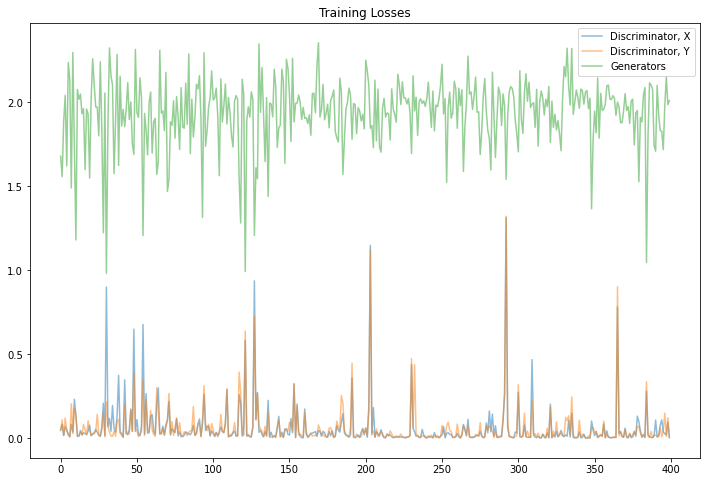

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [29]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


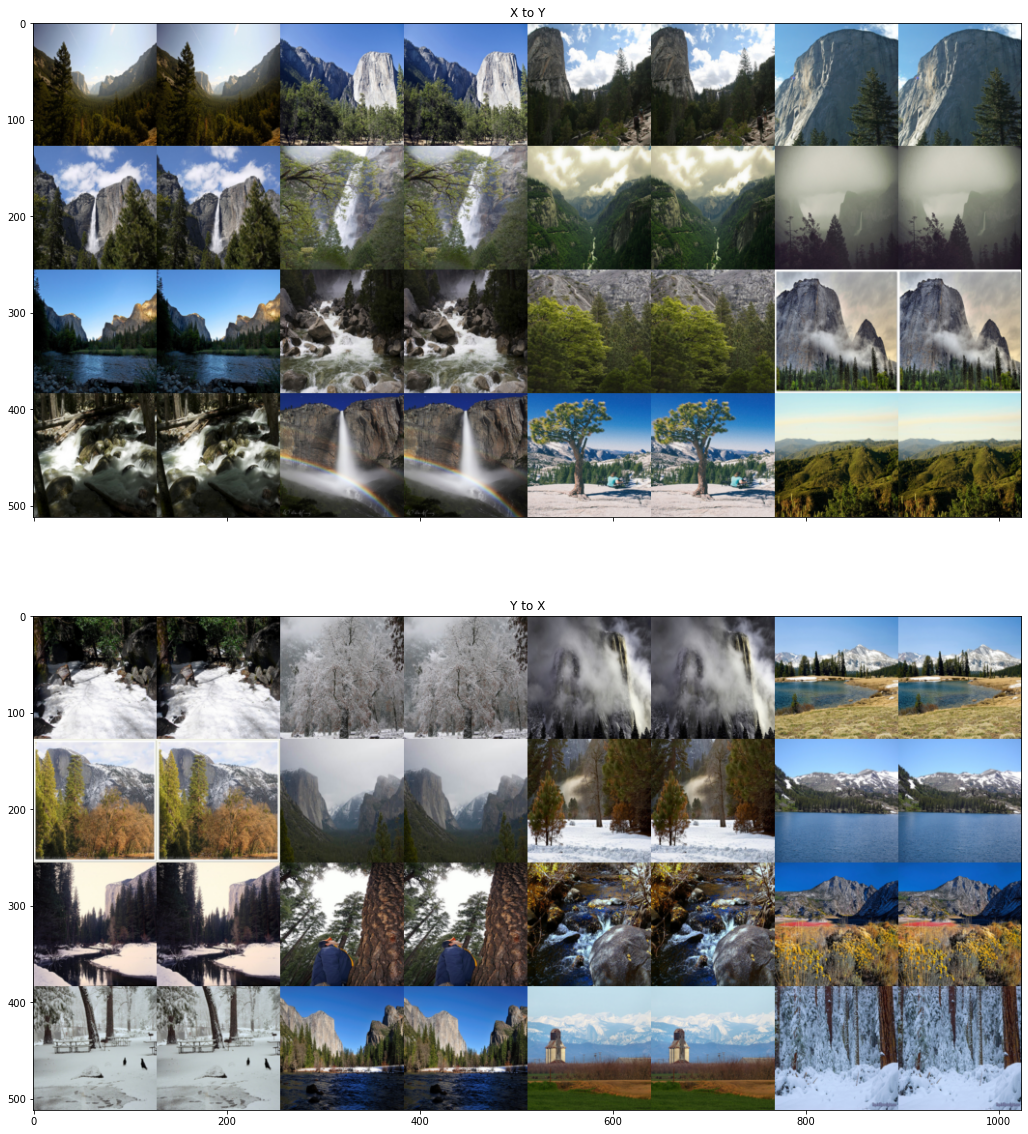

In [30]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

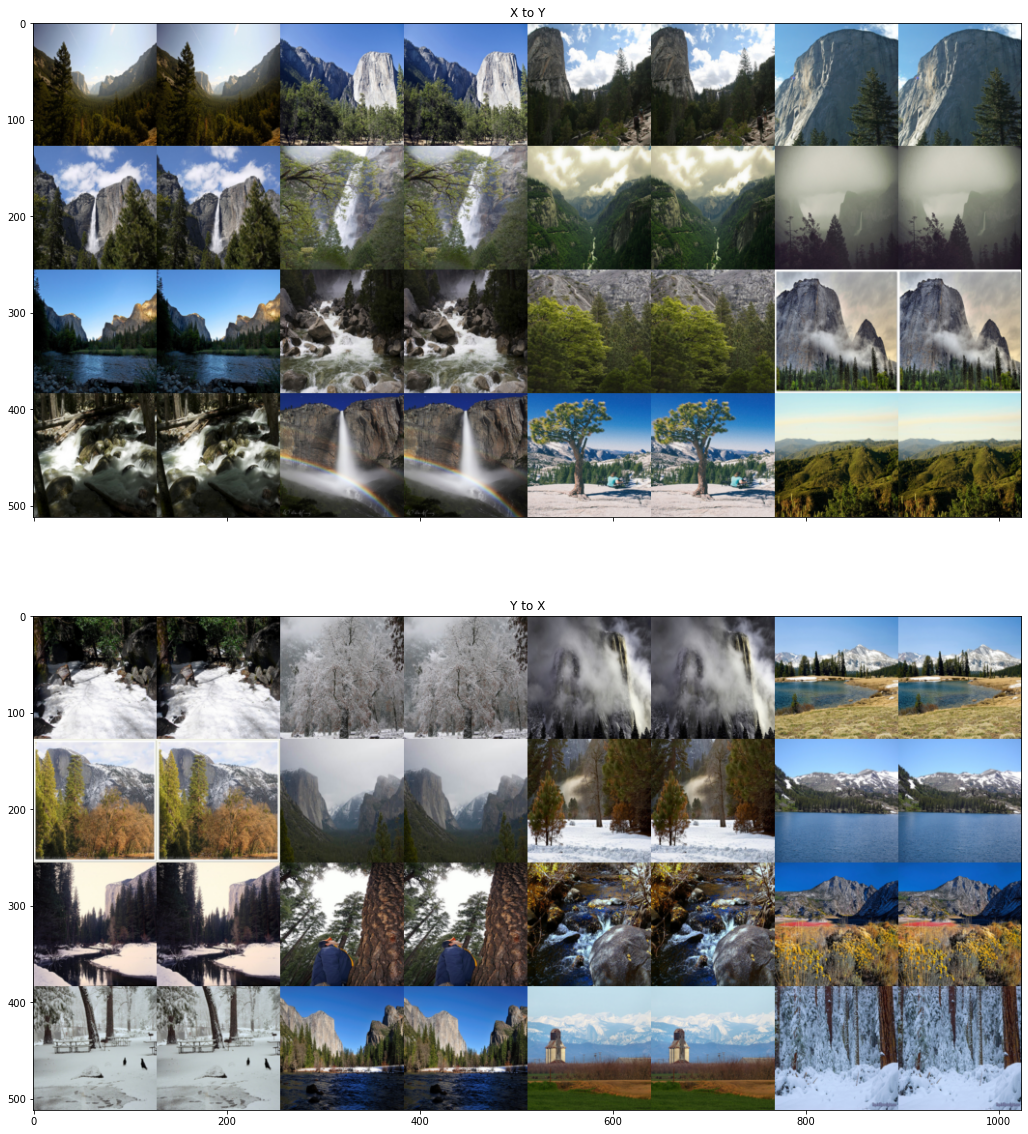

In [33]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.